

> ## Clustering-Assignment



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


# Step1:Load a dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
columns = ['Class', 'Alcohol', 'Malic_Acid', 'Ash', 'Alcalinity_of_Ash', 'Magnesium',
           'Total_Phenols', 'Flavanoids', 'Nonflavanoid_Phenols', 'Proanthocyanins',
           'Color_Intensity', 'Hue', 'OD280/OD315', 'Proline']
df = pd.read_csv(url, header=None, names=columns)
X = df.drop('Class', axis=1)

# Step2:Preprocessing Methods

In [3]:
scaler = StandardScaler()
normal_data = scaler.fit_transform(X)

minmax_scaler = MinMaxScaler()
normalized_data = minmax_scaler.fit_transform(X)

transformer = PowerTransformer()
transformed_data = transformer.fit_transform(X)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(X)

# Step3:Combination Preprocessing

In [4]:
combined_data = scaler.fit_transform(transformed_data)
combined_pca_data = pca.fit_transform(combined_data)


# Step4:Preprocessed Data Dictionary

In [5]:
preprocessed_data = {
    "No Processing": X.values,
    "Standardized": normal_data,
    "Normalized": normalized_data,
    "Transformed": transformed_data,
    "PCA": pca_data,
    "T+N": combined_data,
    "T+N+PCA": combined_pca_data
}

# Step5:Clustering Algorithms

In [9]:
def perform_clustering(data, algorithms, n_clusters=3):
    results = []
    for name, algo in algorithms:
        model = algo.fit(data)
        if hasattr(model, 'labels_'):
            labels = model.labels_
        else:
            labels = model.predict(data)

        # Check number of unique labels
        n_labels = len(set(labels))
        if n_labels < 2:
            print(f"Warning: Algorithm {name} produced {n_labels} labels for the given data.")
            continue

        silhouette = silhouette_score(data, labels)
        ch_score = calinski_harabasz_score(data, labels)
        db_score = davies_bouldin_score(data, labels)
        results.append({
            "Algorithm": name,
            "Silhouette Score": silhouette,
            "Calinski-Harabasz": ch_score,
            "Davies-Bouldin": db_score
        })
    return pd.DataFrame(results)


# Step6:Algorithms to Test

In [7]:
algorithms = [
    ("K-Means", KMeans(n_clusters=3, random_state=42)),
    ("Hierarchical", AgglomerativeClustering(n_clusters=3)),
    ("DBSCAN", DBSCAN(eps=1.5, min_samples=5)),
    ("Mean Shift", MeanShift()),
    ("GMM", GaussianMixture(n_components=3, random_state=42))
]

# Step7:Evaluate Clustering

In [10]:
for key, data in preprocessed_data.items():
    print(f"Results for {key}:")
    results = perform_clustering(data, algorithms)
    print(results)
    print("\n")

Results for No Processing:
      Algorithm  Silhouette Score  Calinski-Harabasz  Davies-Bouldin
0       K-Means          0.559582         497.004876        0.549558
1  Hierarchical          0.564480         552.851712        0.535734
2    Mean Shift          0.502492         454.058943        0.556150
3           GMM          0.347266         266.220922        0.815476


Results for Standardized:
      Algorithm  Silhouette Score  Calinski-Harabasz  Davies-Bouldin
0       K-Means          0.284859          70.940008        1.389188
1  Hierarchical          0.277444          67.647468        1.418592
2    Mean Shift          0.224476           6.435434        1.320059
3           GMM          0.284859          70.940008        1.389188


Results for Normalized:
      Algorithm  Silhouette Score  Calinski-Harabasz  Davies-Bouldin
0       K-Means          0.300894          83.351128        1.308640
1  Hierarchical          0.294829          81.327639        1.318311
2           GMM       

# Step8:Visualize PCA with K-Means

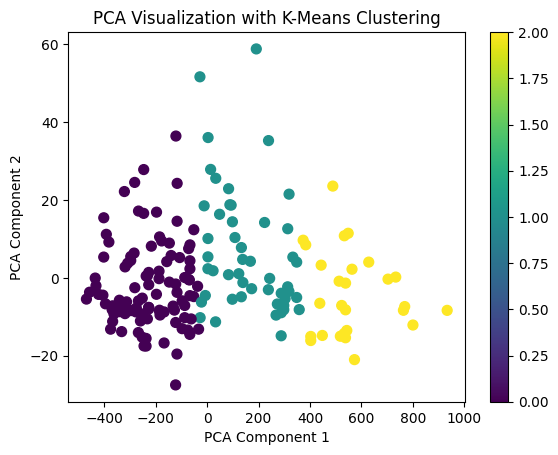

In [11]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_data)

plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.title("PCA Visualization with K-Means Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar()
plt.show()

# More visualizations

## Cluster Heatmap:
 For feature-wise comparison of clusters.


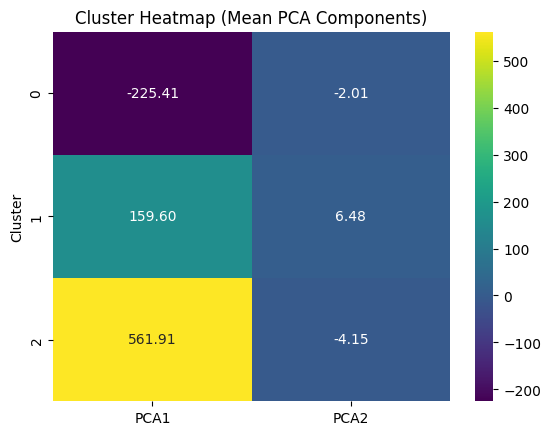

In [12]:
import seaborn as sns
import pandas as pd

# Create a DataFrame with cluster labels and PCA data
clustered_data = pd.DataFrame(pca_data, columns=["PCA1", "PCA2"])
clustered_data["Cluster"] = kmeans_labels

# Compute mean values for each cluster
cluster_means = clustered_data.groupby("Cluster").mean()

# Plot heatmap
sns.heatmap(cluster_means, annot=True, cmap="viridis", fmt=".2f")
plt.title("Cluster Heatmap (Mean PCA Components)")
plt.show()


## Silhouette Analysis:
To evaluate the clustering quality.

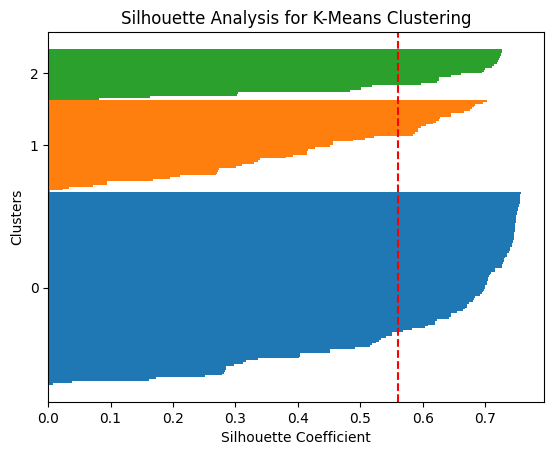

In [13]:
from sklearn.metrics import silhouette_samples

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_data)

silhouette_vals = silhouette_samples(pca_data, kmeans_labels)
y_ticks = []
y_lower, y_upper = 0, 0

for i, cluster in enumerate(np.unique(kmeans_labels)):
    cluster_silhouette_vals = silhouette_vals[kmeans_labels == cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1.0)
    y_ticks.append((y_lower + y_upper) / 2)
    y_lower += len(cluster_silhouette_vals)

plt.axvline(np.mean(silhouette_vals), color="red", linestyle="--")
plt.title("Silhouette Analysis for K-Means Clustering")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Clusters")
plt.yticks(y_ticks, np.unique(kmeans_labels))
plt.show()


## Elbow Method Plot:
 For selecting the optimal number of clusters.

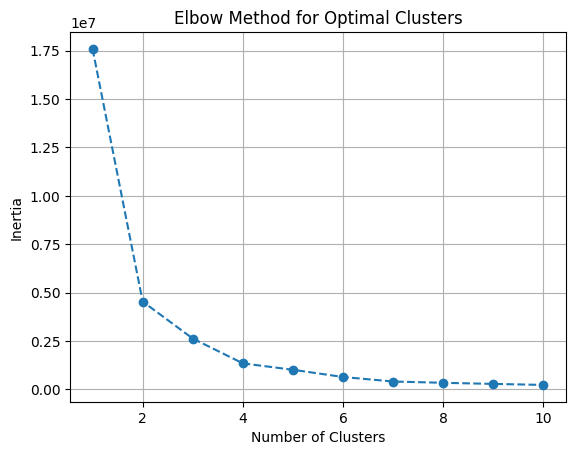

In [14]:
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    inertia.append(kmeans.inertia_)

plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()
